In [1]:
import sys
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import os
import bigbadbrain as bbb
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy
from scipy.ndimage.filters import gaussian_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d

from skimage.filters import threshold_triangle
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages')
import os
import statsmodels.api as sm
import cv2
import matplotlib.patches as mpatches
import psutil
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.colors import Normalize


%matplotlib inline
plt.rcParams.update({'font.size': 20})

from sklearn.feature_extraction.image import grid_to_graph
from mpl_toolkits.axes_grid1 import ImageGrid
import json
from matplotlib.ticker import FuncFormatter

import nibabel as nib

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import itertools
import random
from scipy.cluster import hierarchy
import matplotlib as mpl
from matplotlib.pyplot import cm

from scipy.interpolate import UnivariateSpline
from sklearn.linear_model import LinearRegression
import matplotlib.patches as patches

from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV

from scipy.fftpack import fft,fftshift,ifft

import pickle

In [2]:
dataset_path = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset"
fly_names = ['fly_087', 'fly_089', 'fly_094', 'fly_097', 'fly_098', 'fly_099', 'fly_100', 'fly_101', 'fly_105']
expt_len = 1000*30*60
resolution = 10
high_res_timepoints = np.arange(0,expt_len,resolution) #0 to last time at subsample res
n_clusters = 2000

class Fictrac:
    def __init__ (self, fly_dir, timestamps):
        self.fictrac_raw = bbb.load_fictrac(os.path.join(fly_dir, 'fictrac'))
        self.timestamps = timestamps
    def make_interp_object(self, behavior):
        # Create camera timepoints
        fps=50
        camera_rate = 1/fps * 1000 # camera frame rate in ms
        expt_len = 1000*30*60
        x_original = np.arange(0,expt_len,camera_rate)

        # Smooth raw fictrac data
        fictrac_smoothed = scipy.signal.savgol_filter(np.asarray(self.fictrac_raw[behavior]),25,3)

        # Create interp object with camera timepoints
        fictrac_interp_object = interp1d(x_original, fictrac_smoothed, bounds_error = False)
        return fictrac_interp_object

    def pull_from_interp_object(self, interp_object, timepoints):
        new_interp = interp_object(timepoints)
        np.nan_to_num(new_interp, copy=False);
        return new_interp

    def interp_fictrac(self):
        behaviors = ['dRotLabY', 'dRotLabZ']; shorts = ['Y', 'Z']
        self.fictrac = {}

        ### Y and Z ###
        for behavior, short in zip(behaviors, shorts):
            interp_object = self.make_interp_object(behavior)
            self.fictrac[short + 'i'] = interp_object

            ### Interpolate to neural data
            self.fictrac[short] = []
            self.fictrac[short + '_pos'] = []
            self.fictrac[short + '_neg'] = []
            for z in range(49):
                ### Velocity ###
                low_res_behavior = self.pull_from_interp_object(interp_object, self.timestamps[:,z])
                self.fictrac[short].append(low_res_behavior/np.std(low_res_behavior))

                ### Clipped Velocities ###
                self.fictrac[short + '_pos'].append(np.clip(self.fictrac[short][-1], a_min=0, a_max=None))
                self.fictrac[short + '_neg'].append(np.clip(self.fictrac[short][-1], a_min=None, a_max=0)*-1)

        ### Walking ###
        self.fictrac['walking'] = []
        for z in range(49):    
            YZ = np.sqrt(np.power(self.fictrac['Y'][z],2), np.power(self.fictrac['Z'][z],2))        
            self.fictrac['walking'].append(np.zeros(3384))
            self.fictrac['walking'][-1][np.where(YZ>.2)] = 1

class Fly:
    def __init__ (self, fly_name, fly_idx):
        self.dir = os.path.join(dataset_path, fly_name, 'func_0')
        self.fly_idx = fly_idx
        self.fly_name = fly_name
        self.maps = {}
    def load_timestamps (self):
        self.timestamps = bbb.load_timestamps(os.path.join(self.dir, 'imaging'))
    def load_fictrac (self):
        self.fictrac = Fictrac(self.dir, self.timestamps)
    def load_brain_slice (self):
        self.brain = brain[:,:,:,self.fly_idx]
    def load_anatomy (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', 'anat-to-meanbrain.nii')
        self.anatomy = np.array(nib.load(to_load).get_data(), copy=True)
    def load_z_depth_correction (self):
        to_load = os.path.join(dataset_path, self.fly_name, 'warp', '20201220_warped_z_depth.nii')
        self.z_correction = np.array(nib.load(to_load).get_data(), copy=True)
    def get_cluster_averages (self, cluster_model_labels, n_clusters):
        neural_data = self.brain.reshape(-1, 3384)
        signals = []
        self.cluster_indicies = []
        for cluster_num in range(n_clusters):
            cluster_indicies = np.where(cluster_model_labels==cluster_num)[0]
            mean_signal = np.mean(neural_data[cluster_indicies,:], axis=0)
            signals.append(mean_signal)
            self.cluster_indicies.append(cluster_indicies) # store for later
        self.cluster_signals=np.asarray(signals)
    def get_cluster_id (self, x, y):
        ax_vec = x*128 + y
        for i in range(n_clusters):
            if ax_vec in self.cluster_indicies[i]:
                cluster_id = i
                break
        return cluster_id

flies = {}
for i, fly in enumerate(fly_names):
    flies[fly] = Fly(fly_name=fly, fly_idx=i)
    flies[fly].load_timestamps()
    flies[fly].load_fictrac()
    flies[fly].fictrac.interp_fictrac()
    flies[fly].load_z_depth_correction()


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 1.01 sec

~~ load_fictrac ~~
load_fictrac done. Duration: 5.43 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 51.56 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.38 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 38.01 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 5.32 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 67.69 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 4.35 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 68.11 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 9.48 sec

~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 71.58

In [3]:
1

1

In [4]:
z = 18

labels_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/cluster_labels.npy'
cluster_model_labels = np.load(labels_file) #z,t
cluster_model_labels = cluster_model_labels[z,:]

brain_file = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20201129_super_slices/superslice_{}.nii".format(z) #<---------- !!!
brain = np.array(nib.load(brain_file).get_data(), copy=True)
fly_idx_delete = 3 #(fly_095)
brain = np.delete(brain, fly_idx_delete, axis=-1) #### DELETING FLY_095 ####

for i, fly in enumerate(fly_names):
    flies[fly].load_brain_slice()
    flies[fly].get_cluster_averages(cluster_model_labels, n_clusters)

scores_all = []

scores_walking = []
scores_ypos = []
scores_zpos = []
scores_zneg = []

scores_walking_unique = []
scores_ypos_unique = []
scores_zpos_unique = []
scores_zneg_unique = []

for cluster_num in range(n_clusters):
    if cluster_num%100 == 0:
        print(cluster_num)
        #printlog(str(cluster_num))
    ###############################################################
    ### Build Y vector for a single supervoxel (with all flies) ###
    ###############################################################
    all_fly_neural = []
    for fly in fly_names:
        signal = flies[fly].cluster_signals[cluster_num,:]
        all_fly_neural.extend(signal)
        Y = np.asarray(all_fly_neural)

    ###########################################
    ### Build the X matrix for this cluster ###
    ###########################################
    # For each fly, this cluster could have originally come from a different z-depth
    # Get correct original z-depth
    ypos = []
    zpos = []
    zneg = []
    walking = []
    for i, fly in enumerate(fly_names):
        cluster_indicies = flies[fly].cluster_indicies[cluster_num]
        z_map = flies[fly].z_correction[:,:,z].ravel()
        original_z = int(np.median(z_map[cluster_indicies]))
        ypos.extend(flies[fly].fictrac.fictrac['Y_pos'][original_z])
        zpos.extend(flies[fly].fictrac.fictrac['Z_pos'][original_z])
        zneg.extend(flies[fly].fictrac.fictrac['Z_neg'][original_z])
        walking.extend(flies[fly].fictrac.fictrac['walking'][original_z])

    ### ALL ###
    #X = np.stack((ypos, zpos, zneg, walking)).T
    X = np.stack((zpos, walking)).T
    model = RidgeCV().fit(X,Y)
    scores_all.append(np.sqrt(model.score(X,Y)))

#     ### Singles ###
#     X = np.reshape(walking, (-1, 1))
#     model = RidgeCV().fit(X,Y)
#     scores_walking.append(np.sqrt(model.score(X,Y)))

#     X = np.reshape(ypos, (-1, 1))
#     model = RidgeCV().fit(X,Y)
#     scores_ypos.append(np.sqrt(model.score(X,Y)))

#     X = np.reshape(zpos, (-1, 1))
#     model = RidgeCV().fit(X,Y)
#     scores_zpos.append(np.sqrt(model.score(X,Y)))

    X = np.reshape(walking, (-1, 1))
    model = RidgeCV().fit(X,Y)
    scores_zneg.append(np.sqrt(model.score(X,Y)))

#     X = np.stack((ypos, walking)).T
#     model = RidgeCV().fit(X,Y)
#     scores_walking_unique.append(np.sqrt(model.score(X,Y)))

#     ### LOO ###
#     X = np.stack((ypos, zpos, zneg)).T
#     model = RidgeCV().fit(X,Y)
#     scores_walking_unique.append(np.sqrt(model.score(X,Y)))

#     X = np.stack((zpos, zneg, walking)).T
#     model = RidgeCV().fit(X,Y)
#     scores_ypos_unique.append(np.sqrt(model.score(X,Y)))

#     X = np.stack((ypos, zneg, walking)).T
#     model = RidgeCV().fit(X,Y)
#     scores_zpos_unique.append(np.sqrt(model.score(X,Y)))

#     X = np.stack((ypos, zpos, walking)).T
#     model = RidgeCV().fit(X,Y)
#     scores_zneg_unique.append(np.sqrt(model.score(X,Y)))

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


In [5]:
z=0
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels[:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_zneg[cluster_num]
    if len(cluster_indicies) > 100:
        colored_by_betas[cluster_indicies] = np.nan
    if colored_by_betas[cluster_indicies][0] == 1:
        colored_by_betas[cluster_indicies] = np.nan
colored_by_betas = colored_by_betas.reshape(256,128)
to_plot = colored_by_betas

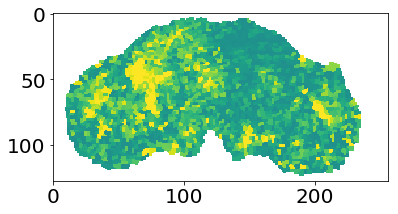

In [9]:
plt.imshow(to_plot.T,vmin=-.01,vmax=.01)
# no signal in SMP! was not opposite turn soaking up

In [6]:
z=0
colored_by_betas = np.zeros(256*128)
for cluster_num in range(n_clusters):
    cluster_indicies = np.where(cluster_model_labels[:]==cluster_num)[0]
    colored_by_betas[cluster_indicies] = scores_all[cluster_num] - scores_zneg[cluster_num]
    if len(cluster_indicies) > 100:
        colored_by_betas[cluster_indicies] = np.nan
    if colored_by_betas[cluster_indicies][0] == 1:
        colored_by_betas[cluster_indicies] = np.nan
colored_by_betas = colored_by_betas.reshape(256,128)
to_plot = colored_by_betas

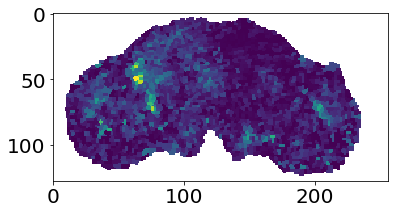

In [7]:
plt.imshow(to_plot.T)

In [9]:
cluster_model_labels.shape

(32768,)